# Neural networks
In this notebook, we explore 2 different neural network architectures that succeeded in predicting sales volumes for a kaggle competition.

## Notebook settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

## Loading data
In order for this to work, download all datasets from kaggle competition:  
https://www.kaggle.com/c/demand-forecasting-kernels-only  
and place them in `../data/` folder.  
We could not append datasets to our repo because of copyrights.

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Before we do anything, we want to have both sets in a format with 500 sales columns and 1 row for each day.

In [3]:
df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [4]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
from itertools import product, starmap


def storeitems():
    return product(range(1,51), range(1,11))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [6]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


We combine data to prepare it for the model, and later split back into train and test set, not to repeat same transformations twice.

In [9]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [10]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


### Features
One-hot encoding day of week and month of year to make sure the networks recognize the seasonality in the data.

In [11]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

In [12]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

In [13]:
df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

In [14]:
assert df_total.isna().any().any() == False

We also want to append sales from previous day to each row, which we will then use as input data.

In [15]:
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, sort=False, copy=False)

In [16]:
df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)

In [17]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1020 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(19)
memory usage: 14.7 MB


We need to make sure that stacked and not-stacked sales columns appar in the same order. We do this by sorting the names (as strings), which works fine because we only need 1 past day for the network (see regression models and their rolling mechanism if you are interested in rolling more than 1 past days of sales as input).

In [18]:
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [19]:
df_total = df_total.reindex(columns=new_cols)

In [20]:
assert df_total.isna().any().any() == False

### Scaling
With combined datasets and shifted sales, we can now correctly min-max scale all data.
This is necessary for neural networks to work as intended.

In [21]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

### Split back to train and test set

In [23]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

## Training models
First, we need to separate training data into input and target vectors, and separate part of training data as validation data for our models.

In [24]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [25]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 519 entries, item_10_store_10_sales_past_1 to month_12
dtypes: float64(500), uint8(19)
memory usage: 7.0 MB


In [27]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

To achieve similar error values as on Kaggle, we will use only 1st quarter of 2017 for validation (test set contains 1st quarter of 2018 and the data is highly seasonal).

In [29]:
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

For Keras, we need to make further transformations on input values:

In [30]:
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

### Defining models

In [31]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

Using TensorFlow backend.


Simple LSTM model:

In [32]:
basic_model = Sequential()
basic_model.add(LSTM(500, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(500))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


More complex model combining LSTM with convolutional layers:

In [33]:
inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(500)(inputs)
top_dense = Dense(500, activation='relu')(top_lstm)
top_dropout = Dropout(500)(top_dense)
# bottom pipeline
bottom_dense = Dense(500)(inputs)
bottom_conv1 = Conv1D(
    500, 
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    1000,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    500,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60, 
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[500]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(500)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

Now we can fit the models:

In [34]:
basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=60, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Instructions for updating:
Use tf.cast instead.
Train on 1460 samples, validate on 90 samples
Epoch 1/60
 - 11s - loss: 0.1494 - val_loss: 0.0936
Epoch 2/60
 - 5s - loss: 0.0945 - val_loss: 0.0749
Epoch 3/60
 - 5s - loss: 0.0833 - val_loss: 0.0688
Epoch 4/60
 - 5s - loss: 0.0735 - val_loss: 0.0629
Epoch 5/60
 - 5s - loss: 0.0744 - val_loss: 0.0602
Epoch 6/60
 - 6s - loss: 0.0793 - val_loss: 0.0667
Epoch 7/60
 - 6s - loss: 0.0723 - val_loss: 0.0736
Epoch 8/60
 - 8s - loss: 0.0954 - val_loss: 0.0880
Epoch 9/60
 - 5s - loss: 0.0820 - val_loss: 0.0715
Epoch 10/60
 - 6s - loss: 0.0806 - val_loss: 0.0735
Epoch 11/60
 - 6s - loss: 0.0744 - val_loss: 0.0598
Epoch 12/60
 - 5s - loss: 0.0675 - val_loss: 0.0811
Epoch 13/60
 - 6s - loss: 0.0735 - val_loss: 0.0578
Epoch 14/60
 - 6s - loss: 0.0620 - val_loss: 0.0569
Epoch 15/60
 - 6s - loss: 0.0602 - val_loss: 0.0567
Epoch 16/60
 - 6s - loss: 0.0604 - val_loss: 0.0576
Epoch 17/60
 - 6s - loss: 0.0610 - val_loss: 0.0627
Epoch 18/60
 - 6s - loss: 0.07

In [35]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

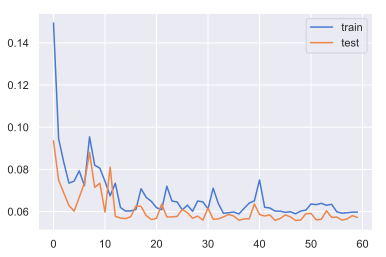

In [36]:
plot_history(basic_history)

In [37]:
complex_history = complex_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=130, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Train on 1460 samples, validate on 90 samples
Epoch 1/130
 - 112s - loss: 0.0559 - mean_absolute_percentage_error: 301.7338 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 24.8777
Epoch 2/130
 - 101s - loss: 0.0131 - mean_absolute_percentage_error: 452.4900 - val_loss: 0.0100 - val_mean_absolute_percentage_error: 21.6792
Epoch 3/130
 - 99s - loss: 0.0099 - mean_absolute_percentage_error: 344.2814 - val_loss: 0.0078 - val_mean_absolute_percentage_error: 18.8908
Epoch 4/130
 - 97s - loss: 0.0090 - mean_absolute_percentage_error: 340.4182 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 19.4381
Epoch 5/130
 - 98s - loss: 0.0090 - mean_absolute_percentage_error: 367.0901 - val_loss: 0.0105 - val_mean_absolute_percentage_error: 23.8389
Epoch 6/130
 - 99s - loss: 0.0090 - mean_absolute_percentage_error: 319.4287 - val_loss: 0.0069 - val_mean_absolute_percentage_error: 18.3958
Epoch 7/130
 - 97s - loss: 0.0083 - mean_absolute_percentage_error: 287.2351 - val_loss: 0.0057 - va

Epoch 58/130
 - 101s - loss: 0.0060 - mean_absolute_percentage_error: 324.5589 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8442
Epoch 59/130
 - 105s - loss: 0.0059 - mean_absolute_percentage_error: 325.9691 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8413
Epoch 60/130
 - 105s - loss: 0.0060 - mean_absolute_percentage_error: 324.6164 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8469
Epoch 61/130
 - 104s - loss: 0.0060 - mean_absolute_percentage_error: 325.3359 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8465
Epoch 62/130
 - 103s - loss: 0.0060 - mean_absolute_percentage_error: 324.6644 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8495
Epoch 63/130
 - 102s - loss: 0.0060 - mean_absolute_percentage_error: 327.4885 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 13.8531
Epoch 64/130
 - 102s - loss: 0.0059 - mean_absolute_percentage_error: 325.7667 - val_loss: 0.0053 - val_mean_absolute_percentage_error: 

Epoch 115/130
 - 101s - loss: 0.0096 - mean_absolute_percentage_error: 343.7041 - val_loss: 0.0052 - val_mean_absolute_percentage_error: 14.2848
Epoch 116/130
 - 100s - loss: 0.0069 - mean_absolute_percentage_error: 340.2157 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.3515
Epoch 117/130
 - 103s - loss: 0.0078 - mean_absolute_percentage_error: 312.9937 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.6411
Epoch 118/130
 - 104s - loss: 0.0077 - mean_absolute_percentage_error: 343.9629 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.0950
Epoch 119/130
 - 104s - loss: 0.0071 - mean_absolute_percentage_error: 340.6062 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.2538
Epoch 120/130
 - 103s - loss: 0.0074 - mean_absolute_percentage_error: 338.5444 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 14.1301
Epoch 121/130
 - 101s - loss: 0.0071 - mean_absolute_percentage_error: 339.2624 - val_loss: 0.0050 - val_mean_absolute_percentage_

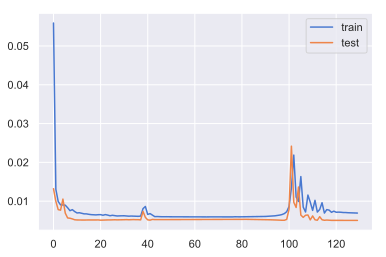

In [38]:
plot_history(complex_history)

## Evaluating model predictions

In [39]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [40]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

In [41]:
y_pred_complex = model_eval(complex_model, X_valid, y_valid)[0]

In [42]:
# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

In [43]:
basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [44]:
basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

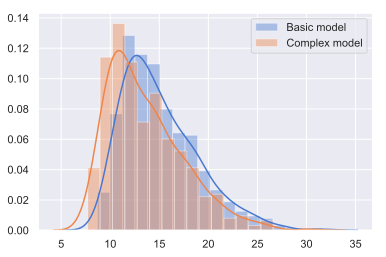

In [45]:
sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

Depending on training parameters, basic model can sometimes achieve results comparable to the complex one, however after uploading to Kaggle complex model achieved better (and more consistent) results.

In [46]:
describe(basic_smapes)

DescribeResult(nobs=500, minmax=(8.68279537566672, 31.673458137269776), mean=15.062762500836179, variance=14.672369368509143, skewness=0.9426355830247264, kurtosis=0.7612876159108777)

In [47]:
describe(complex_smapes)

DescribeResult(nobs=500, minmax=(7.698379831269427, 30.41061966457535), mean=13.582426547663815, variance=14.781640997129134, skewness=0.978439714445401, kurtosis=0.7906372943444961)

### Visualizing model prediction
We will plot predictions of 2 models for a sample store and item.

In [48]:
store, item = 1,1
plot_lengths = [7, 30, 90]
rolling_mean_windows = [1, 1, 2]  # to make plots more readable

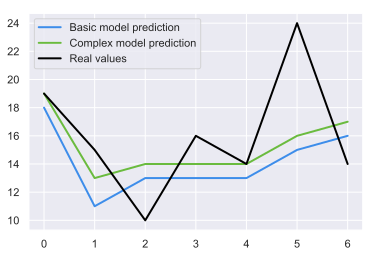

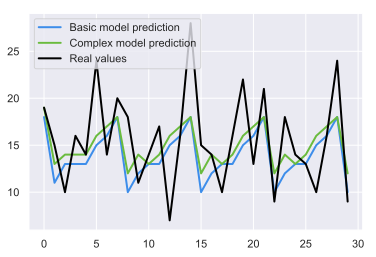

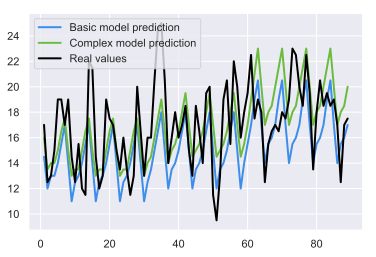

In [49]:
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(basic_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()